This first block handles all the most important imports and needs to be run every time.

In [1]:
import numpy                 as     np
import numpy.linalg          as     npl                 
import scipy                 as     sp
from   scipy                 import ndimage    as ndi
import pandas as pd
import seaborn as sns
import re
import shutil
import glob

from   skimage               import data
from   skimage.util          import img_as_float
from   skimage.filters       import gabor_kernel
from   sklearn.preprocessing import scale

from   numbers               import Number   

import os, sys, math, itertools, collections

%matplotlib notebook
#%gui qt
import matplotlib
import matplotlib.pyplot     as     plt

import neuropythy            as     neuro
import neuropythy.freesurfer as     nfs

for p in ['/home/billbrod/Documents/SCO-test-data/Freesurfer_subjects', '/Volumes/server/Freesurfer_subjects/']:
    if p not in nfs.subject_paths():
        nfs.add_subject_path(p)

import sco
import freq_pref_check
import model_comparison_script

def reload_sco():
    reload(sys.modules['sco.core'])
    reload(sys.modules['sco.anatomy.core'])
    reload(sys.modules['sco.stimulus.core'])
    reload(sys.modules['sco.pRF.core'])
    reload(sys.modules['sco.normalization.core'])
    reload(sys.modules['sco.anatomy'])
    reload(sys.modules['sco.stimulus'])
    reload(sys.modules['sco.pRF'])
    reload(sys.modules['sco.normalization'])
    reload(sys.modules['sco'])
    reload(sys.modules['sco.model_comparison'])
    reload(sys.modules['sco.model_comparison.core'])
    import sco

## Comparison with MATLAB results

Now, use the Makefile to create the full dataframe. This works but I feel like it takes longer then it should and it doesn't print things along the way, which is annoying. Can also call this from the command line, in which case each of the make steps will announce themselves (and so is a little easier to see progress).

If you do that, skip the following and go right to the next code block

In [38]:
%%bash
export PATH=$PATH:/Applications/MATLAB_R2014a8.3.app/bin/
make fullclean
make MATLAB_soc_model_params.csv

Process is terminated.


Load in the stimuli, stimuli info, and model dataframe so we don't need to do this in the call to visualize_model_comparison

In [2]:
stimuli_idx = np.asarray(range(156))+69
model_df = pd.read_csv("MATLAB_soc_model_params.csv")
stimulus_model_names = sco.model_comparison.core._load_pkl_or_mat("soc_model_params_image_names.mat", 'image_names')
stimuli_descriptions = sco.model_comparison.core._load_pkl_or_mat("sco/model_comparison/stimuliNames.mat", 'stimuliNames')
stimuli_descriptions = stimuli_descriptions[0, stimuli_idx]
stimuli_descriptions = np.asarray([i[0] for i in stimuli_descriptions])
stimuli = sco.model_comparison.core._load_pkl_or_mat("stimuli.mat", 'images')
stimuli = stimuli[0, :]

Set the conditions and titles you want to visualize for. Entries of `conditions` are either strings (in which case we plot those stimuli whose corresponding `stimuli_descriptions` equals that value) or lists of ints (in which case we plot the stimuli whose indices correspond to those ints). The following lists contain all of the "default options" (as would be plotted if `make images` or `python2.7 sco/model_comparison/core.py` were called). For this notebook, you should probably pick a subset for speed.

In [3]:
all_conditions = ['grating_ori', 'grating_contrast', 'plaid_contrast', 'circular_contrast',
                  [180, 181, 182, 84, 183], range(131, 138), range(69, 100), range(100, 131),
                  range(131, 158)+[180, 181, 182, 84, 183]]
all_condition_titles = ['orientations', 'gratings', 'plaid', 'circular', 'sparse', 'size',
                        'horizontal sweep', 'vertical sweep','full']
all_plot_kwargs = [{}, {}, {}, {}, {}, {}, {}, {},
                   {'hue': 'image_name', 'col': 'language', 'col_wrap': None}]

In [4]:
plot_idx = 0
conditions = [all_conditions[plot_idx]]
titles = [all_condition_titles[plot_idx]]
plot_kwargs = [all_plot_kwargs[plot_idx]]
plot_kwargs[0].update(size=5)

<IPython.core.display.Javascript object>


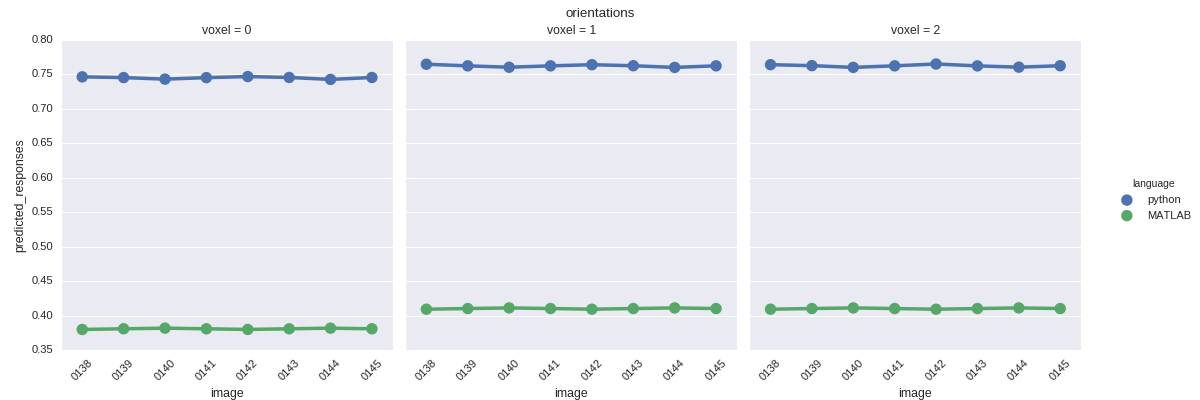

<IPython.core.display.Javascript object>


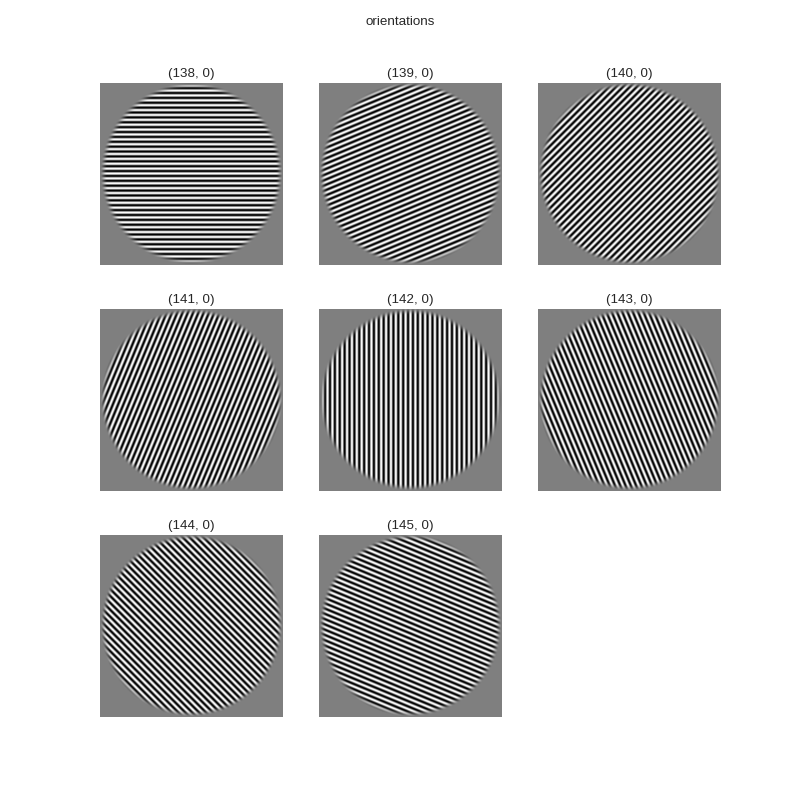

In [5]:
sco.model_comparison.visualize_model_comparison(conditions, titles, model_df, stimulus_model_names, stimuli_descriptions, stimuli, stimuli_idx, plot_kwargs)

## Spatial frequency preference

In the matlab version of this model (as described in Kay et al, 2013), we only dealt with one spatial frequency (3 cycles per degree). In this version, we want to be able to handle multiple spatial frequencies. In order to check that we're doing what we think we are, we use `freq_pref_check.py`. 

There are three things we want to check, and this script enables us to look at all three:

1. For a given preferred spatial frequency (in cycles per degree) and stimulus pixels per degree, generate model predictions on a collection of images with different spatial frequencies (cycles per image), then see which produces the greatest predicted response. In this case, we set our parameters so that the cycles per image in the stimulus end up being the cyles per image in the normalized image that the model operates on.

2. For a given preferred spatial frequency (in cycles per degree) and image (with a given cycles per image), vary the stimulus pixels per degree so that the effective cycles per degree in the normalized image varies, and see which produces the greatest predicted response.

3. For a given image and stimulus pixels per degree, vary the preferred spatial frequency and see which produces the greatest predicted response.

Note that number 3 takes much longer than the others. And it appears that the lower the preferred spatial frequency, the longer it takes.

Exploring the full space takes a fair amount of time, looking at a variety of images, stimulus pixels per degree, and preferred spatial frequencies. Calling the script from the command line (which calls the function `check_full_space`) will do this, but it takes some time and it's recommended to submit as an array job to the cluster (and has been built to facilitate this).

For speed, in this notebook, we instead do what the points above suggest and hold two of the components constant while varying the third. We can do this all in one call (to `main`) or in separate calls (to `check_pref_across_frequencies`, `check_pref_across_pixels_per_degree`, and `check_response_across_prefs`, respectively). We provide cells that do it both ways, but for speed it's recommended to do it in separate calls.

### Separate calls

Run the following two cells, then pick which one you want to see

In [2]:
# These are the parameters

#NOTHING ELSE SHOULD BE IN THIS FOLDER
img_folder = os.path.expanduser("~/Desktop/freq_pref_imgs")
model_df_path = "./sco_freq_prefs.csv"
subject = "test-sub"
subject_dir = None
output_img_path = "./sco_freq_prefs.svg"
normalized_pixels_per_degree = 12
img_res = 1000
max_eccentricity = 7.5
#this needs to be an array
freqs = np.asarray(range(30))

In [3]:
# we only want those we just created
if os.path.isdir(img_folder):
    shutil.rmtree(img_folder)

# 2*max_eccentricity is the size of the image in degrees
stimulus_pixels_per_degree = float(img_res) / (2*max_eccentricity)
    
freq_pref_check.generate_stimuli(img_folder, freqs+1, img_res, stimulus_pixels_per_degree)

model_kwargs = dict(subject=subject, subject_dir=subject_dir,
              stimulus_pixels_per_degree=stimulus_pixels_per_degree,
              normalized_pixels_per_degree=normalized_pixels_per_degree,
              # in order to avoid having edge effects be very large, we set
              # stimulus_aperture_edge_width to 20 to get some smoothness between the image and
              # the surrounding area.
              stimulus_aperture_edge_width=20, max_eccentricity=max_eccentricity)

The following shows an arbitrary image generated by our code (which will serve as one of the stimuli for the model). The image is a 2d horizontal sinusoidal grating at a given frequency, with a second sine wave at a much lower frequency crossfaded in. Because our model has the second order contrast component, if our input image is a simple sinusoidal graitng, we have no variation in contrast and thus our response is driven by edge effects. With the crossfade, more of the image contributes and the signal at those points has the proper frequency.

<IPython.core.display.Javascript object>


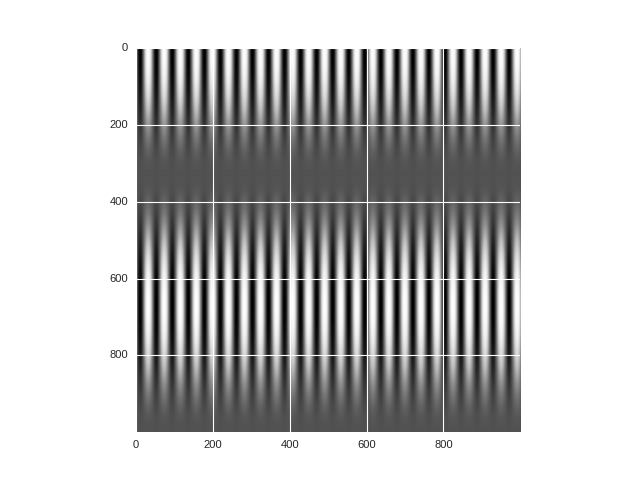

In [9]:
img=plt.imread(glob.glob(img_folder+"/*.png")[0])
plt.figure()
plt.imshow(img)

For given preferred frequency and pixels per degree, check across frequencies. The preferred frequency is one cycle per degree, so that's where we should see the peak response.

sco/model_comparison/core.py:64: UserWarning: Results key pRF_views is not in any of our default key sets!
  warnings.warn("Results key %s is not in any of our default key sets!" % k)
sco/model_comparison/core.py:64: UserWarning: Results key stimulus_gamma is not in any of our default key sets!
  warnings.warn("Results key %s is not in any of our default key sets!" % k)


<IPython.core.display.Javascript object>


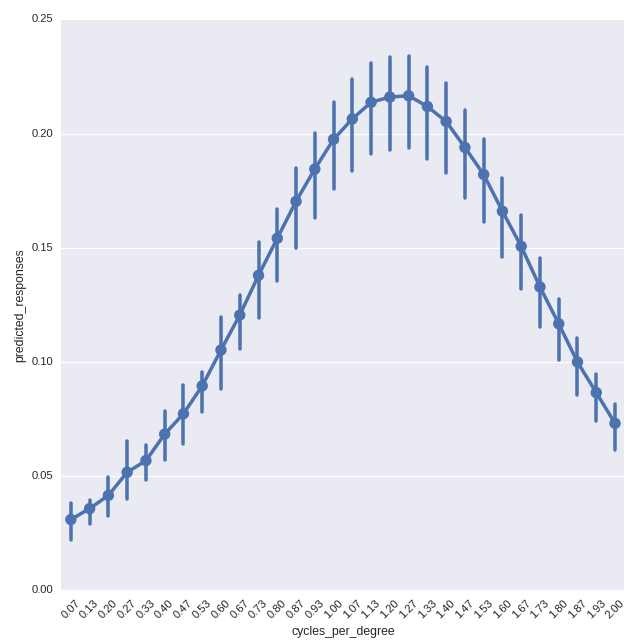

In [4]:
model_df, results, plot_df, g = freq_pref_check.check_pref_across_frequencies(
    img_folder, os.path.splitext(output_img_path)[0]+"_pref_across_freqs.svg",
    os.path.splitext(model_df_path)[0]+"_pref_across_freqs.csv", np.array(range(30)),
    img_size=img_res, **model_kwargs)

For a given preferred frequency and cycles per image, check across stimulus pixels per degre (and thus effective cycles per degree). The preferred frequency is one cycle per degree, so that's where we should see the peak response.

<IPython.core.display.Javascript object>


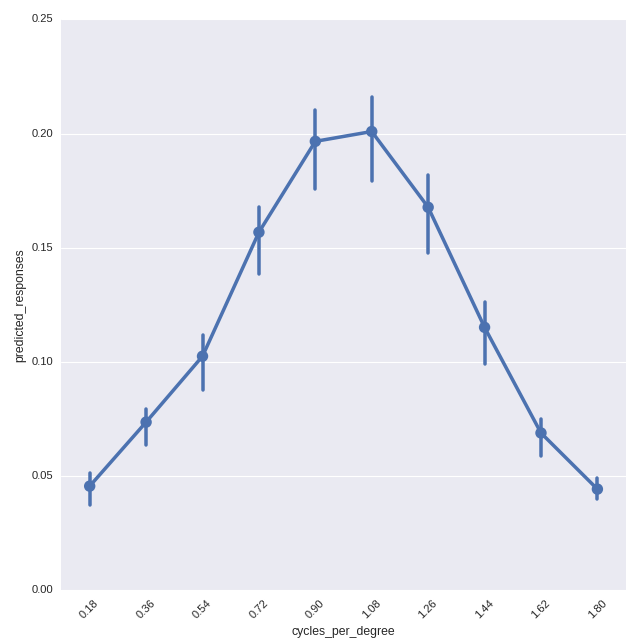

In [11]:
model_df, results, plot_df, g = freq_pref_check.check_pref_across_pixels_per_degree(
    img_folder, os.path.splitext(output_img_path)[0]+"_pref_across_d2p.svg",
    os.path.splitext(model_df_path)[0]+"_pref_across_d2p.csv", np.array([29]), img_size=img_res,
    **model_kwargs)

For a given cycles per degree (so holding both cycles per image and stimulus pixels per degree constant), check across preferred frequencies.

<IPython.core.display.Javascript object>


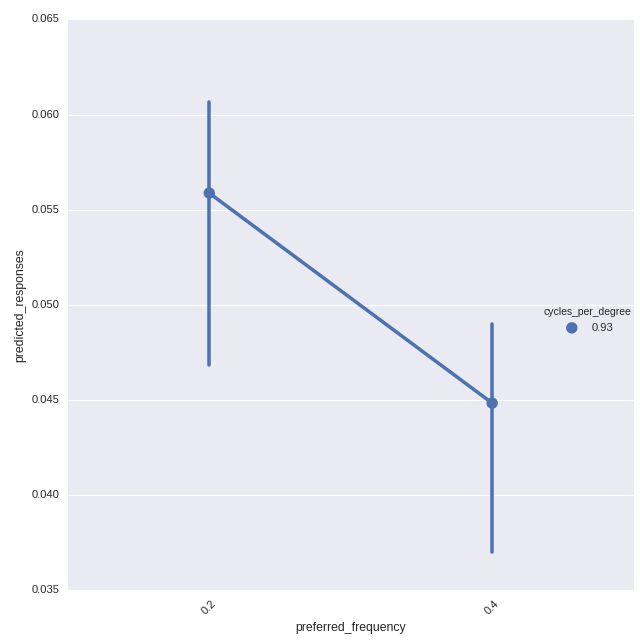

In [12]:
model_df, results, plot_df, g = freq_pref_check.check_response_across_prefs(
    img_folder, os.path.splitext(output_img_path)[0]+"_resp_across_prefs.svg",
    os.path.splitext(model_df_path)[0]+"_resp_across_prefs.csv", np.array([14]), img_size=img_res,
    **model_kwargs)

### All in one call

In [ ]:
freq_pref_check.main()

### Full space

The following cells are for after you've run `check_full_space` and then want to visualize the results.

In [4]:
template_string = "/home/billbrod/Documents/SCO-test-data/freq_pref_check/sco_freq_prefs_freq*.csv"
img_size_in_pixels = 1000
img_size_in_degrees = 15
df = freq_pref_check.combine_dfs(template_string, "./sco_full_space_freq_prefs.csv")
plot_df = sco.model_comparison.core._create_plot_df(df)
plot_df = plot_df[plot_df.language=='python']
# in the naive case, we assume none of the image was cut out of the aperture, and so the number
# of cycles per image is given by the frequency of the generating sine wave.
plot_df['cycles_per_full_image'] = plot_df['image'].apply(lambda x: int(re.search(r'freq_([0-9]+)', x).groups()[0]))
# we try to grab the pixels per degree, if it's there.
plot_df['pix_per_deg'] = plot_df['image'].apply(lambda x: float(re.search(r'pix_per_deg_([\.0-9]+)', x).groups()[0]))
plot_df['cycles_per_norm_image'] = plot_df.apply(lambda x: x['cycles_per_full_image']*(x['pix_per_deg']/(img_size_in_pixels/img_size_in_degrees)), axis=1)
plot_df['cycles_per_degree'] = plot_df['cycles_per_norm_image'].astype(float)/img_size_in_degrees
# want to make this look good
plot_df['cycles_per_degree'] = plot_df['cycles_per_degree'].map(lambda x: "{:.02f}".format(x)).astype(float)
plot_df['preferred_frequency'] = plot_df['image'].apply(lambda x: float(re.search(r'freq_pref_([\.0-9]+)', x).groups()[0]))

From the plot below, which shows the differetn preferred frequencies in different axes, with the cycles per degree on the x axis, predicted response on the y axis, and visual area shown via the color, we see that the peak occurs where it should.

<IPython.core.display.Javascript object>


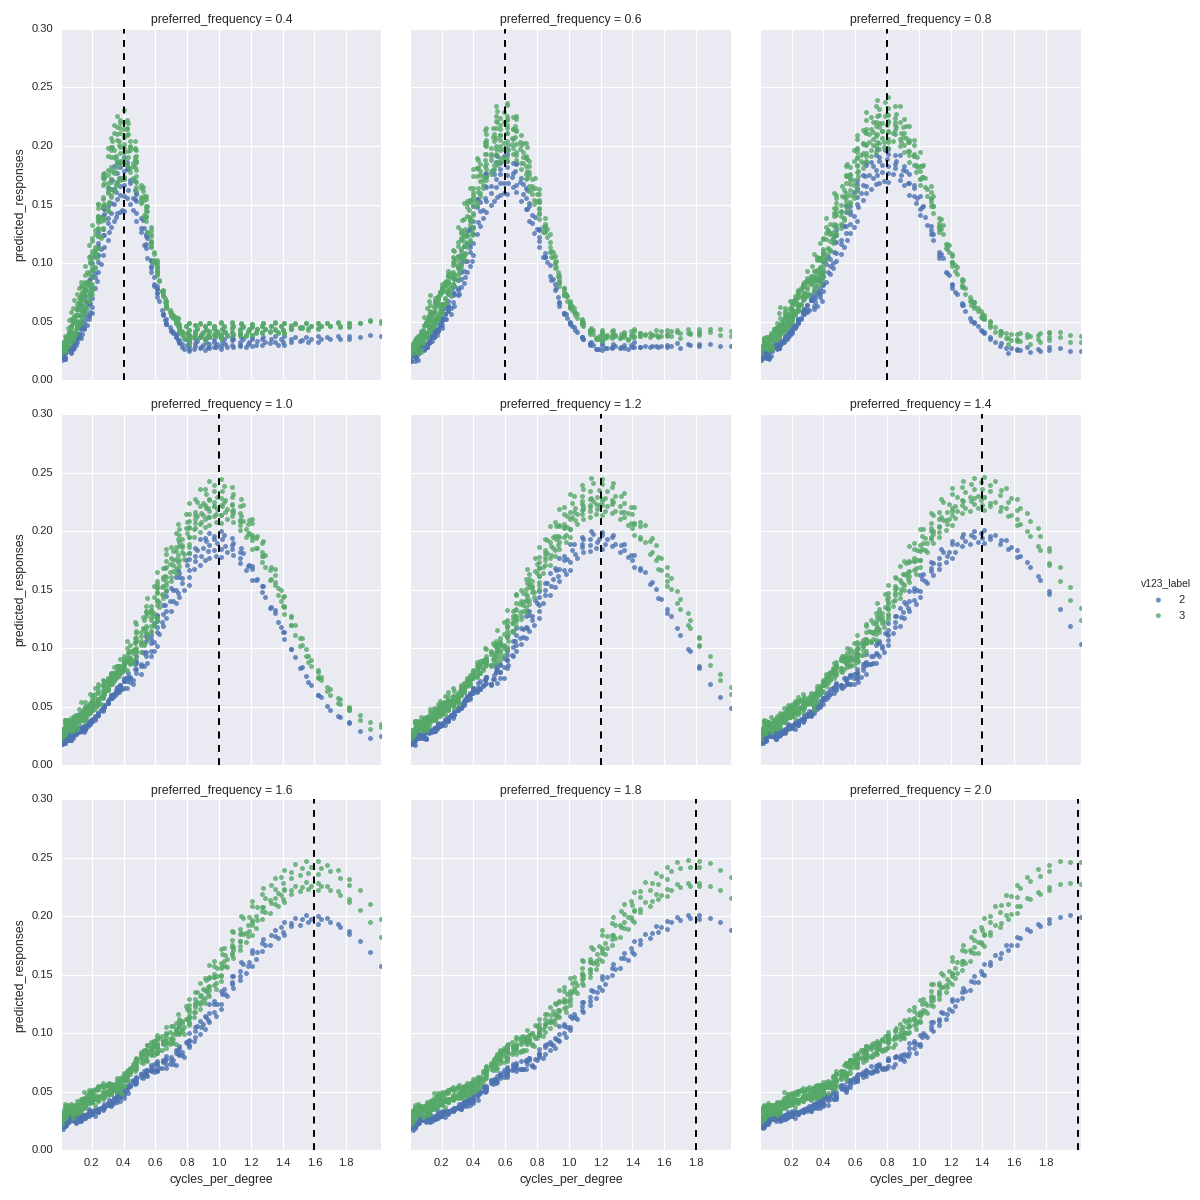

In [9]:
g= sns.lmplot(data=plot_df, x='cycles_per_degree', y='predicted_responses', col='preferred_frequency', hue='v123_label', size=5, col_wrap=3, fit_reg=False,
              legend_out=True)
ylim = None
xticklabels = None
xlim = [plot_df.cycles_per_degree.min(), plot_df.cycles_per_degree.max()]
for (i,j,k), data in g.facet_data():
    ax = g.facet_axis(i,j)
    if ylim is None:
        ylim = list(ax.get_ylim())
    if xticklabels is None:
        xticklabels = ax.get_xticklabels()
    if not data.empty:
        pref_freq = data.preferred_frequency.unique()[0] #there will only be one
        ax.plot([pref_freq, pref_freq], ylim, 'k--')
g.set(ylim=ylim, xlim=xlim, xticks=[i/5. for i in range(10)])
g.fig.subplots_adjust(right=.9)